<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/AUC%26AVG_Loss(per_Epochs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 KB 6.9 MB/s eta 0:00:00


In [21]:
# imports
import pickle

from scipy.integrate import simps

import torch
torch.cuda.empty_cache()

import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc

In [22]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [23]:
# Adding an encoder with three convolutional layers (nn.Conv2d), and one fully-connected linear output layer. 
# We will use a kernel of size 3, with padding of 1 and stride of 2 for the CNN hyperparameters.
# Also adding a Batch Norm layer between convolutional layers. Since will be using the neuron membrane potential as outputs from each neuron, 
# normalization will help our training process.
#Define the SAE model:


class SAE(nn.Module):
    def __init__(self):
        super().__init__()


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, 
                                # bias=True, padding_mode='zeros',  device=None, dtype=None)
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data

        # When decoding the latent z-space data, we need to move from the flattened encoded representation (latent_dim) back to a tensor representation to 
            # use in transposed convolution.
          # To do so, we need to run an additional fully-connected linear layer transforming the data back into a tensor of 128 x 4 x 4:
        
        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))
                                      #snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))




      #  The decoder, with three transposed convolutional (nn.ConvTranspose2d) layers and one linear output layer. 
      # Although we converted the latent data back into tensor form for convolution, we still need to Unflatten it to a tensor of 128 x 4 x 4, 
        # as the input to the network is 1 dimensional.  This is done using nn.Unflatten in the first line of the Decoder:
        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
        # final Leaky layer, our spiking threshold (thresh) is set extremely high. This is a neat trick in snnTorch, which allows the neuron 
        # membrane in the final layer to continuously be updated, without ever reaching a spiking threshold.
        
        # using the membrane potential output from the final layer for the image reconstruction. 
            # snnTorch allows us to use either the spikes or membrane potential of each neuron in training. 

    def forward(self, x):
  # need to reset the hidden weights of each LIF neuron. 
  # If we do not do this, we will get weird gradient errors from pytorch when we try to backprop. 
  # To do so we use utils.reset.
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)


# calling the encode and decode functions in a loop because we are converting static images into spike trains.
# Spike trains need a time, t, during which spiking can occur or not occur. Therefore, we encode and decode the original image 
#   t (or num_steps) times, to create a latent representation, z.
    
    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        encoded_x=[];
        for step in range(num_steps): #for t in time
            spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
        
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)

        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension
# torch.stack joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension. 

    #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        for step in range(num_steps): #for t in time
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])

            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)
        out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        return out

    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x

    # def encode(self, x, scheduled=False):
    #     x = self.encoder(x) # (N,C,H,W,T)
    #     x = torch.flatten(x, start_dim=1, end_dim=3) # (N,C*H*W,T)
    #     latent_x = self.before_latent_layer(x) # (N,latent_dim,T)
    #     sampled_z, q_z = self.posterior(latent_x) # sampled_z:(B,C,1,1,T), q_z:(B,C,k,T)

    #     p_z = self.prior(sampled_z, scheduled, self.p)
    #     return sampled_z, q_z, p_z

    # def decode(self, z):
    #     result = self.decoder_input(z) # (N,C*H*W,T)
    #     result = result.view(result.shape[0], self.hidden_dims[-1], 2, 2, self.n_steps) # (N,C,H,W,T)
    #     result = self.decoder(result)# (N,C,H,W,T)
    #     result = self.final_layer(result)# (N,C,H,W,T)
    #     out = torch.tanh(self.membrane_output_layer(result))        
    #     return out

    # def sample(self, batch_size=64):
    #     sampled_z = self.prior.sample(batch_size)
    #     sampled_x = self.decode(sampled_z)
    #     return sampled_x, sampled_z

    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2

In [24]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)




def train(network, trainloader, opti, epoch):
    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]
    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)

        #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
        x_recon = network(real_img) #Dimensions passed in: [Batch_size,Input_size,Image_Width,Image_Length]

        #Calculate loss
        # Avg Loss:
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        # avg_loss = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)
          # loss_val = F.mse_loss(x_recon[:, :, :, step], real_img)
          # avg_loss += loss_val
        # train_loss_hist.append(loss_val.item())
        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()
        # train_avg_loss_rec.append(avg_loss.item())

        # # Print train/test loss/accuracy
        # if counter % 50 == 0:
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')
        # counter += 1

        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            # NOTE: you need to create training/ and testing/ folders in your chosen path
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)
    return loss_val, train_loss_rec , train_auc #, train_avg_loss_rec, #avg_loss #, train_loss_hist




# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []

    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            labels = labels.to(device)
            x_recon = network(real_img)

            # loss_val = F.mse_loss(x_recon, real_img)
            # average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())
            # test_avg_loss_rec.append(avg_loss.item()) # NEW LINE
            # test_avg_loss_hist.append(avg_loss.item())


            # # Print train/test loss/accuracy
            # if counter % 50 == 0: 
            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}')#, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')
            # counter += 1
            
            test_loss_rec.append(loss_val.item())
            # test_avg_loss_rec.append(avg_loss.item())

            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

    return loss_val, test_loss_rec, test_auc #, test_avg_loss_rec #, test_loss_hist



# calculating loss with spiking neural networks
# taking the membrane potential of the final fully-connected layer of neurons at the last time step (t=5)

# # We can also return the membrane potentials at each time step, and create t different versions of the reconstructed image, and then compare each of them with the original image. 
# # For taking the average loss, you can replace the loss function above with something like this:
# train_loss_hist=[]
# loss_val = torch.zeros((1), dtype=dtype, device=device)
# for step in range(num_steps):
#     loss_val += F.mse_loss(x_recon, real_img)
# train_loss_hist.append(loss_val.item())
# avg_loss=loss_val/num_steps


In [25]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')

In [26]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CPU


In [27]:
start_time = datetime.datetime.now()

# Defining some parameters, and run training and testing
# dataloader arguments
# batch_size = 128
# batch_size = 250
input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)


# # Temporal Dynamics
# num_steps = 25
# # Rsyn=1
# # Rmem=1
# # Cmem=5e-3
# # Csyn=5e-3
# beta=0.95
# R2=5
# C=1e-3
# time_step=1e-3
# threshold=1


# //////////////////////////////////range for beta//////////////////////// 
train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]

# beta=np.linspace(0.5,0.99,3)

# for i in range(np.size(np.linspace(0.5,0.99,3))):
#   print('for beta = %.2f ' %beta[i])
# # for beta in np.linspace(0.5,0.99,3):
#   # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
#   alpha=0.9
#   beta_syn=0.9
#   # beta = 0.7 #decay rate of neuron
#   beta= beta[i]
#   num_steps=5
#   latent_dim = 32 #dimension of latent layer (how compressed we want the information)
#   thresh=1    #spiking threshold (lower = more spikes are let through)
#   epochs=1
#   max_epoch=epochs

#   #Define Network and optimizer
#   net=SAE()
#   net = net.to(device)

#   optimizer = torch.optim.AdamW(net.parameters(),
#                             lr=0.0001,
#                             betas=(0.9, 0.999),
#                             weight_decay=0.001)



#    #Run training and testing
#   for e in range(epochs):
#     train_loss = train(net, train_loader, optimizer, e)
#     # train_loss_rec.append(loss_val.item())

#     test_loss = test(net,test_loader,optimizer,e)
#     # loss_val_rec.append(loss_val.item())

#   train_loss_record.append(train_loss_rec)             
#   test_loss_record.append(test_loss_rec)
#   beta=np.linspace(0.5,0.99,3)
# ///////////////////////////////////////////////////////////////////// 






# ///////////////////////////////////////////////////////////////////// 
  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
beta_syn=0.0
# beta = 0.7 #decay rate of neuron
beta = beta=0.2
num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=50
max_epoch=epochs

  #Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)





In [ ]:

   #Run training and testing
for e in range(epochs):

  train_loss = train(net, train_loader, optimizer, e)
  train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

  
  test_loss = test(net,test_loader,optimizer,e)
  test_avg_loss_rec.append(sum(test_loss_rec)/(len(test_loader)))
# ///////////////////////////////////////////////////////////////////// 






In [ ]:
print('shape of train_loss_rec',np.shape(train_loss_rec))
print('shape of test_loss_rec',np.shape(test_loss_rec))

print('shape of train_avg_loss_rec', np.array(train_avg_loss_rec).shape)
print('shape of test_avg_loss_rec', np.array(test_avg_loss_rec).shape)

print('\\\\\\\\\\\\\\\\\\\\\\ \n')



In [ ]:
print(' --------------------------(Train_loss_rec)----------------- ')

print(' Shape of (train_loss_rec): ', np.shape(train_loss_rec))
print('   First item in train_loss_rec: ', train_loss_rec[:1])
print('   Last item in train_loss_rec: ', train_loss_rec[np.size(train_loss_rec)-1:])

print(' --------------------------(Test_loss_rec)----------------- ')
print(' Shape of (Test_loss_rec): ', np.shape(test_loss_rec))
print('   First item in Test_loss_rec: ', test_loss_rec[:1])
print('   Last item in Test_loss_rec: ', test_loss_rec[np.size(test_loss_rec)-1:])

In [ ]:
print(' --------------------------(train_avg_loss_rec)----------------- ')

print(' Shape of (train_avg_loss_rec): ', np.shape(train_avg_loss_rec))
print('   First item in train_avg_loss_rec: ', train_avg_loss_rec[:1])
print('   Last item in train_avg_loss_rec: ', train_avg_loss_rec[np.size(train_avg_loss_rec)-1:])

print(' --------------------------(test_avg_loss_rec)----------------- ')
print(' Shape of (test_avg_loss_rec): ', np.shape(test_avg_loss_rec))
print('   First item in test_avg_loss_rec: ', test_avg_loss_rec[:1])
print('   Last item in test_avg_loss_rec: ', test_avg_loss_rec[np.size(test_avg_loss_rec)-1:])



In [ ]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))



# Plot training loss in first subplot
ax1.plot(train_loss_rec)
ax1.set_title("Training Loss Curves", fontweight="bold")
# ax1.legend(["Train Loss (%r epochs)" %epochs+ "\n" + "alpha=%r, beta_syn=%r, beta=%r, num_steps=%r, latent_dim=%r, thresh=%r" %(alpha, beta_syn, beta, num_steps, latent_dim, thresh)])
ax1.legend(["Training Loss (%r epochs)" %epochs + "\n" + "\n" +
            " alpha=%r \n beta_syn=%r \n beta=%r \n thresh=%r" 
            %(alpha, beta_syn, beta, thresh)])
ax1.set_xlabel("Iteration", fontweight="bold")
ax1.set_ylabel("Training Loss", fontweight="bold")

# Plot test loss in second subplot
ax2.plot(test_loss_rec, color='r')
ax2.set_title("Test Loss Curves", fontweight="bold")
ax2.legend(["Test Loss (%r epochs)" %epochs + "\n" + "\n" +
            " alpha=%r \n beta_syn=%r \n beta=%r \n thresh=%r" 
            %(alpha, beta_syn, beta, thresh)])

# ax2.legend(["Test Loss (%r epochs)" %epochs + "\n" + "alpha=%r, beta_syn=%r, beta=%r, num_steps=%r, latent_dim=%r, thresh=%r" %(alpha+ \n , beta_syn, beta, num_steps, latent_dim, thresh)])
ax2.set_xlabel("Iteration", fontweight="bold")
ax2.set_ylabel("Test Loss", fontweight="bold")

# Display the figure
plt.show()


In [ ]:
from sklearn.metrics import auc
import numpy as np
from scipy.integrate import simps


# Calculate the AUC of train_loss_rec
train_auc = simps(train_loss_rec, dx=1)
# Print the AUC value
print("AUC of train_loss_rec: ", train_auc)

# Create a figure with four subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
# --------------------------------------------------------------------------------------------
# Plot AUC for training loss in third subplot
ax1.plot(np.arange(len(train_loss_rec)), train_loss_rec)
# Fill the area under the curve with color
ax1.fill_between(np.arange(len(train_loss_rec)), train_loss_rec, 0, alpha=0.2)
ax1.text(0.5, 0.5, "AUC = " + str(round(train_auc, 4)), transform=ax1.transAxes)
# ax1.axis("off")
ax1.set_title("Training AUC Curves", fontweight="bold")
ax1.legend(["Training AUC (%r epochs)" %epochs + "\n" + "\n" +
            " alpha=%r \n beta_syn=%r \n beta=%r \n thresh=%r" 
            %(alpha, beta_syn, beta, thresh)])
ax1.set_xlabel("Iteration", fontweight="bold")
ax1.set_ylabel("Training Loss", fontweight="bold")




# Calculate the AUC of train_loss_rec
test_auc = simps(test_loss_rec, dx=1)
# Print the AUC value
print("AUC of test_loss_rec: ", test_auc)

# Plot AUC for test loss in fourth subplot
ax2.plot(np.arange(len(test_loss_rec)), test_loss_rec, color='r')
# Fill the area under the curve with color
ax2.fill_between(np.arange(len(test_loss_rec)), test_loss_rec, 0, alpha=0.2, color='red')
ax2.text(0.5, 0.5, "AUC = " + str(round(test_auc, 4)), transform=ax2.transAxes)
# ax2.axis("off")
ax2.set_title("Test AUC Curves", fontweight="bold")
ax2.legend(["Test AUC (%r epochs)" %epochs + "\n" + "\n" +
            " alpha=%r \n beta_syn=%r \n beta=%r \n thresh=%r" 
            %(alpha, beta_syn, beta, thresh)])
ax2.set_xlabel("Iteration", fontweight="bold")
ax2.set_ylabel("Test Loss", fontweight="bold")

# Display the figure
plt.show()


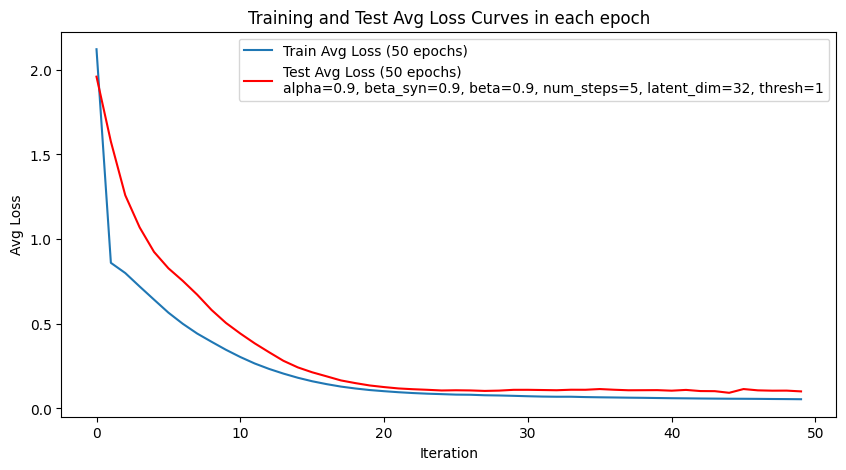

In [ ]:

# a=(sum(train_loss_rec[11760:12000]) / len(train_loader)).  to check the avg of loss per epoch
# print('a:',a)

# -----------------------Calculating train_avg_loss_rec

train_avg_loss_rec=[]
for e in range(1, epochs+1):
  new=(sum(train_loss_rec[((e-1)*len(train_loader)):e*len(train_loader)]) / len(train_loader))
  train_avg_loss_rec.append(new)
  # print(train_avg_loss_rec)


test_avg_loss_rec=[]
for e in range(1, epochs+1):
  new_t=(sum(test_loss_rec[((e-1)*len(test_loader)):e*len(test_loader)]) / len(test_loader))
  test_avg_loss_rec.append(new_t)
  # print(test_avg_loss_rec)


# Plot Average Loss for Training and Test Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_avg_loss_rec)
plt.plot(test_avg_loss_rec, color='r')
plt.title("Training and Test Avg Loss Curves in each epoch")
# plt.legend(["Train Avg Loss (%r epochs)" %epochs, "Test Avg Loss (%r epochs)" %epochs])
plt.legend(["Train Avg Loss (%r epochs)" %epochs , "Test Avg Loss (%r epochs)" %epochs + "\n" + "alpha=%r, beta_syn=%r, beta=%r, num_steps=%r, latent_dim=%r, thresh=%r" %(alpha, beta_syn, beta, num_steps, latent_dim, thresh)])
plt.xlabel("Iteration")
plt.ylabel("Avg Loss")
plt.show()

AUC of test_avg_loss_rec:  14.847236453353737
AUC of train_avg_auc_rec:  10.13695202494661


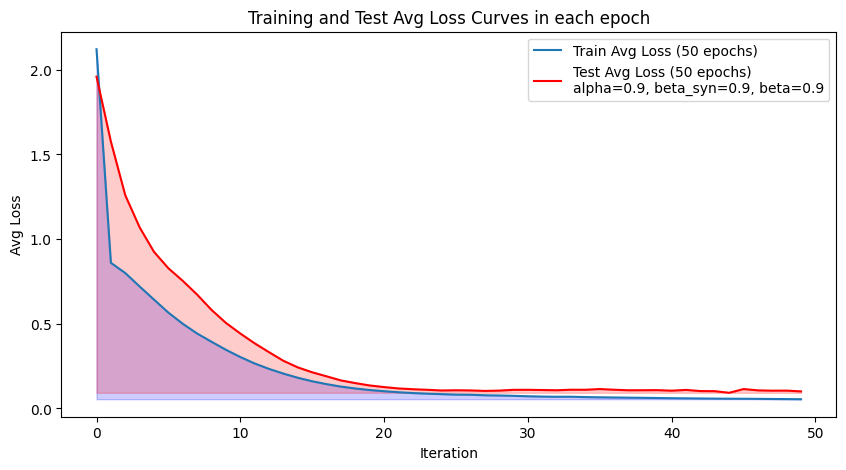

In [ ]:
from sklearn.metrics import auc
import numpy as np
from scipy.integrate import simps

train_avg_loss_rec=[]
for e in range(1, epochs+1):
  new=(sum(train_loss_rec[((e-1)*len(train_loader)):e*len(train_loader)]) / len(train_loader))
  train_avg_loss_rec.append(new)

test_avg_loss_rec=[]
for e in range(1, epochs+1):
  new_t=(sum(test_loss_rec[((e-1)*len(test_loader)):e*len(test_loader)]) / len(test_loader))
  test_avg_loss_rec.append(new_t)

# Calculate the area under the curve for train and test loss
train_avg_auc = simps(train_avg_loss_rec, dx=1.0)
test_avg_auc = simps(test_avg_loss_rec, dx=1.0)

print("AUC of test_avg_loss_rec: ", test_avg_auc)
print("AUC of train_avg_auc_rec: ", train_avg_auc)

# Plot Average Loss for Training and Test Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_avg_loss_rec)
plt.plot(test_avg_loss_rec, color='r')
plt.title("Training and Test Avg Loss Curves in each epoch")
plt.legend(["Train Avg Loss (%r epochs)" %epochs , "Test Avg Loss (%r epochs)" %epochs + "\n" + "alpha=%r, beta_syn=%r, beta=%r" %(alpha, beta_syn, beta)])
plt.xlabel("Iteration")
plt.ylabel("Avg Loss")

# Add fill_between to plot AUC for train and test loss
plt.fill_between(x=range(epochs), y1=train_avg_loss_rec, alpha=0.2, color='blue', y2=min(train_avg_loss_rec))
plt.fill_between(x=range(epochs), y1=test_avg_loss_rec, alpha=0.2, color='red', y2=min(test_avg_loss_rec))
# plt.fill_between(x=range(epochs), y1=test_avg_loss_rec, alpha=0.2, color='red', y2=0)

# Add text to show AUC values
# plt.text(epochs-1, train_avg_loss_rec[0], "Train_avg AUC: {:.3f}".format(train_avg_auc), ha='left')
# plt.text(epochs-1, test_avg_loss_rec[0], "Test_avg AUC: {:.3f}".format(test_avg_auc), ha='right')

plt.show()

In [13]:
# Save AUC to file
with open('AUC.pkl', 'wb') as f:
    pickle.dump({'train_auc': train_auc, 'test_auc': test_auc}, f)

from google.colab import files
files.download('AUC.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Save loss_rec_SAE to file
with open('loss_rec_SAE.pkl', 'wb') as f:
    pickle.dump({'train_loss_rec': train_loss_rec, 'test_loss_rec': test_loss_rec}, f)

from google.colab import files
files.download('loss_rec_SAE.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:

# Save avg_loss_rec_SAE to file
with open('avg_loss_rec_SAE.pkl', 'wb') as f:
    pickle.dump({'train_avg_loss_rec': train_avg_loss_rec, 'test_avg_loss_rec': test_avg_loss_rec}, f)

from google.colab import files
files.download('avg_loss_rec_SAE.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# print('shape of train_loss_rec',np.shape(train_loss_rec))
# print('shape of test_loss_rec',np.shape(test_loss_rec))
# print('\\\\\\\\\\\\\\\\\\\\\\ \n')


# print('shape of train_avg_loss_rec', np.array(train_avg_loss_rec).shape)
# print('shape of test_avg_loss_rec', np.array(test_avg_loss_rec).shape)

# print('\\\\\\\\\\\\\\\\\\\\\\ \n')


In [ ]:
print(' --------------------------(Train_loss_rec)----------------- ')

print(' Shape of (train_loss_rec): ', np.shape(train_loss_rec))
print('   First item in train_loss_rec: ', train_loss_rec[:1])
print('   Last item in train_loss_rec: ', train_loss_rec[np.size(train_loss_rec)-1:])

print(' --------------------------(Test_loss_rec)----------------- ')
print(' Shape of (Test_loss_rec): ', np.shape(test_loss_rec))
print('   First item in Test_loss_rec: ', test_loss_rec[:1])
print('   Last item in Test_loss_rec: ', test_loss_rec[np.size(test_loss_rec)-1:])

In [20]:
# ////////////////////////////////////// just for printing elapsed time
def format_time(seconds):
    if seconds < 300:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 3600:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

dt = datetime.datetime.now() - start_time
t = format_time(dt.total_seconds())

end_time = datetime.datetime.now()
dt = datetime.datetime.now() - start_time
seconds = dt.total_seconds()
t = format_time(seconds)
print("time: %s " % (t))
# /////////////////////////////////////////////////

time: 34.95 minutes 


In [ ]:
#--------------------------- Load the files:

import pickle


with open('loss_rec_SAE(normal).pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_rec_0 = data['train_loss_rec']
test_loss_rec_0 = data['test_loss_rec']

with open('avg_loss_rec_SAE(normal).pkl', 'rb') as f:
    data = pickle.load(f)
train_avg_loss_rec_0 = data['train_avg_loss_rec']
test_avg_loss_rec_0 = data['test_avg_loss_rec']


# Load the AUC file
with open('AUC(normal).pkl', 'rb') as f:
    AUC_data = pickle.load(f)
# Access the train and test AUC values
train_auc_0 = AUC_data['train_auc']
test_auc_0 = AUC_data['test_auc']

# ------------------------------------------------------------------- 1



with open('loss_rec_SAE(beta_syn=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_rec_1 = data['train_loss_rec']
test_loss_rec_1 = data['test_loss_rec']

with open('avg_loss_rec_SAE(beta_syn=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_avg_loss_rec_1 = data['train_avg_loss_rec']
test_avg_loss_rec_1 = data['test_avg_loss_rec']


# Load the AUC file
with open('AUC (beta_syn=0.005).pkl', 'rb') as f:
    AUC_data = pickle.load(f)
# Access the train and test AUC values
train_auc_1 = AUC_data['train_auc']
test_auc_1 = AUC_data['test_auc']

# ------------------------------------------------------------------- 2
with open('loss_rec_SAE(alpha=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_rec_2 = data['train_loss_rec']
test_loss_rec_2 = data['test_loss_rec']

with open('avg_loss_rec_SAE(alpha=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_avg_loss_rec_2 = data['train_avg_loss_rec']
test_avg_loss_rec_2 = data['test_avg_loss_rec']

# Load the AUC file
with open('AUC(alpha=0.005).pkl', 'rb') as f:
    AUC_data = pickle.load(f)
# Access the train and test AUC values
train_auc_2 = AUC_data['train_auc']
test_auc_2 = AUC_data['test_auc']
# ------------------------------------------------------------------- 3

with open('loss_rec_SAE(alpha,beta_syn=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_rec_3 = data['train_loss_rec']
test_loss_rec_3 = data['test_loss_rec']


with open('avg_loss_rec_SAE(alpha,beta_syn=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_avg_loss_rec_3 = data['train_avg_loss_rec']
test_avg_loss_rec_3 = data['test_avg_loss_rec']

# Load the AUC file
with open('AUC(alpha,beta_syn=0.005).pkl', 'rb') as f:
    AUC_data = pickle.load(f)
# Access the train and test AUC values
train_auc_3 = AUC_data['train_auc']
test_auc_3 = AUC_data['test_auc']
# ------------------------------------------------------------------- 4

with open('loss_rec_SAE(beta=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_rec_4 = data['train_loss_rec']
test_loss_rec_4 = data['test_loss_rec']


with open('avg_loss_rec_SAE(beta=0.005).pkl', 'rb') as f:
    data = pickle.load(f)
train_avg_loss_rec_4 = data['train_avg_loss_rec']
test_avg_loss_rec_4 = data['test_avg_loss_rec']


# Load the AUC file
with open('AUC(beta=0.005).pkl', 'rb') as f:
    AUC_data = pickle.load(f)
# Access the train and test AUC values
train_auc_4 = AUC_data['train_auc']
test_auc_4 = AUC_data['test_auc']
# -------------------------------------------------------------------

# with open('avg_loss_rec_SAE(beta_syn=0.005).pkl', 'rb') as f:
#     data = pickle.load(f)

# train_avg_loss_rec = data['train_avg_loss_rec']
# test_avg_loss_rec = data['test_avg_loss_rec']

Text(0, 0.5, 'Test Loss')

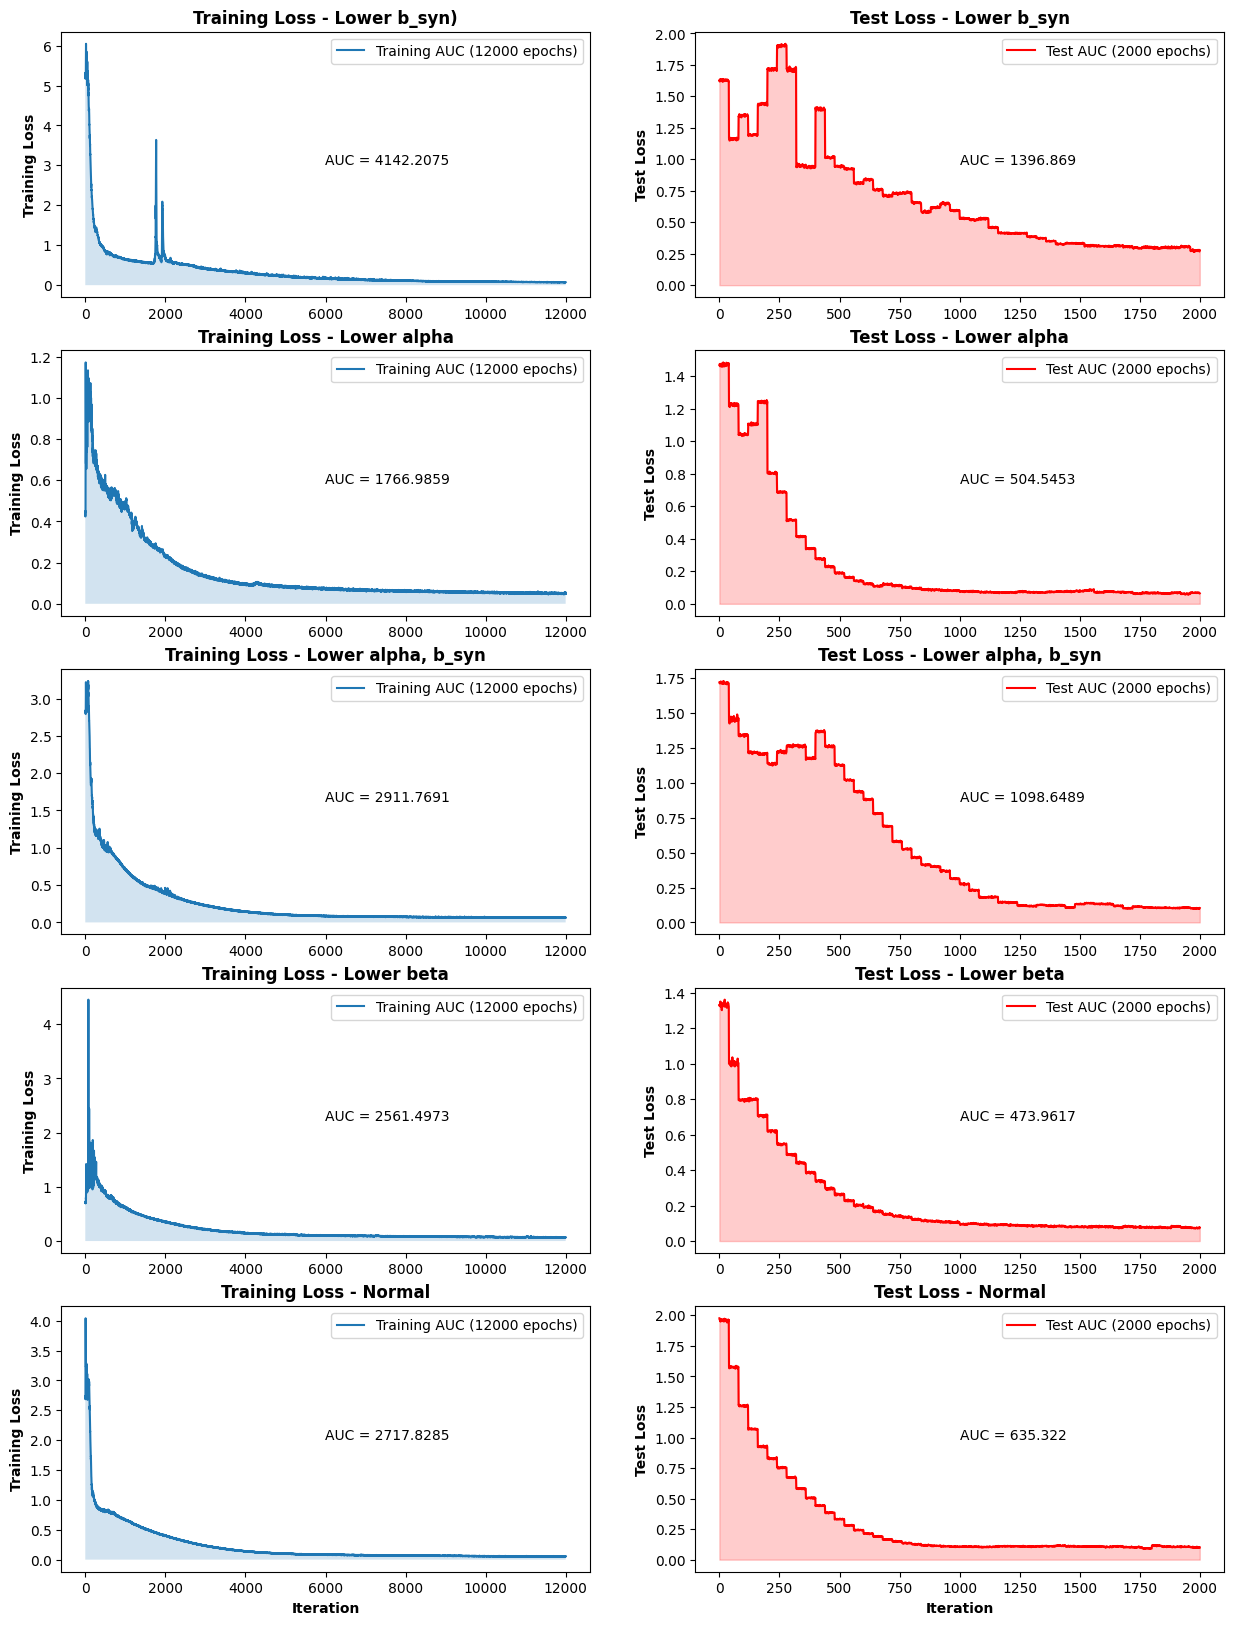

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 20))

# Plot AUC for training loss in first subplot
ax1.plot(np.arange(len(train_loss_rec_1)), train_loss_rec_1)
# Fill the area under the curve with color
ax1.fill_between(np.arange(len(train_loss_rec_1)), train_loss_rec_1, 0, alpha=0.2)
ax1.text(0.5, 0.5, "AUC = " + str(round(train_auc_1, 4)), transform=ax1.transAxes)
ax1.set_title("Training Loss - Lower b_syn)", fontweight="bold")
ax1.legend(["Training AUC (%r epochs)" %len(train_loss_rec_1)])
# ax1.set_xlabel("Iteration", fontweight="bold")
ax1.set_ylabel("Training Loss", fontweight="bold")

# Plot AUC for test loss in second subplot
ax2.plot(np.arange(len(test_loss_rec_1)), test_loss_rec_1, color='r')
# Fill the area under the curve with color
ax2.fill_between(np.arange(len(test_loss_rec_1)), test_loss_rec_1, 0, alpha=0.2, color='red')
ax2.text(0.5, 0.5, "AUC = " + str(round(test_auc_1, 4)), transform=ax2.transAxes)
ax2.set_title("Test Loss - Lower b_syn", fontweight="bold")
ax2.legend(["Test AUC (%r epochs)" %len(test_loss_rec_1)])
# ax2.set_xlabel("Iteration", fontweight="bold")
ax2.set_ylabel("Test Loss", fontweight="bold")
# -----------------------------------------------------------------------------    2
# Plot AUC for training loss in third subplot
ax3.plot(np.arange(len(train_loss_rec_2)), train_loss_rec_2)
# Fill the area under the curve with color
ax3.fill_between(np.arange(len(train_loss_rec_2)), train_loss_rec_2, 0, alpha=0.2)
ax3.text(0.5, 0.5, "AUC = " + str(round(train_auc_2, 4)), transform=ax3.transAxes)
ax3.set_title("Training Loss - Lower alpha", fontweight="bold")
ax3.legend(["Training AUC (%r epochs)" %len(train_loss_rec_2)])
# ax3.set_xlabel("Iteration", fontweight="bold")
ax3.set_ylabel("Training Loss", fontweight="bold")

# Plot AUC for test loss in fourth subplot
ax4.plot(np.arange(len(test_loss_rec_2)), test_loss_rec_2, color='r')
# Fill the area under the curve with color
ax4.fill_between(np.arange(len(test_loss_rec_2)), test_loss_rec_2, 0, alpha=0.2, color='red')
ax4.text(0.5, 0.5, "AUC = " + str(round(test_auc_2, 4)), transform=ax4.transAxes)
ax4.set_title("Test Loss - Lower alpha", fontweight="bold")
ax4.legend(["Test AUC (%r epochs)" %len(test_loss_rec_2)])
# ax4.set_xlabel("Iteration", fontweight="bold")
ax4.set_ylabel("Test Loss", fontweight="bold")

# --------------------------------------------------------------------------------------------
# Scenario 3
# --------------------------------------------------------------------------------------------

# Plot AUC for training loss in fifth subplot
ax5.plot(np.arange(len(train_loss_rec_3)), train_loss_rec_3)
ax5.fill_between(np.arange(len(train_loss_rec_3)), train_loss_rec_3, 0, alpha=0.2)
ax5.text(0.5, 0.5, "AUC = " + str(round(train_auc_3, 4)), transform=ax5.transAxes)
ax5.set_title("Training Loss - Lower alpha, b_syn", fontweight="bold")
ax5.legend(["Training AUC (%r epochs)" %len(train_loss_rec_3)])
# ax5.set_xlabel("Iteration", fontweight="bold")
ax5.set_ylabel("Training Loss", fontweight="bold")

# Plot AUC for test loss in sixth subplot
ax6.plot(np.arange(len(test_loss_rec_3)), test_loss_rec_3, color='r')
ax6.fill_between(np.arange(len(test_loss_rec_3)), test_loss_rec_3, 0, alpha=0.2, color='red')
ax6.text(0.5, 0.5, "AUC = " + str(round(test_auc_3, 4)), transform=ax6.transAxes)
ax6.set_title("Test Loss - Lower alpha, b_syn", fontweight="bold")
ax6.legend(["Test AUC (%r epochs)" %len(test_loss_rec_3)])
# ax6.set_xlabel("Iteration", fontweight="bold")
ax6.set_ylabel("Test Loss", fontweight="bold")


# --------------------------------------------------------------------------------------------
# Scenario 4
# --------------------------------------------------------------------------------------------

# Plot AUC for training loss in seventh subplot
ax7.plot(np.arange(len(train_loss_rec_4)), train_loss_rec_4)
ax7.fill_between(np.arange(len(train_loss_rec_4)), train_loss_rec_4, 0, alpha=0.2)
ax7.text(0.5, 0.5, "AUC = " + str(round(train_auc_4, 4)), transform=ax7.transAxes)
ax7.set_title("Training Loss - Lower beta", fontweight="bold")
ax7.legend(["Training AUC (%r epochs)" %len(train_loss_rec_4)])
# ax7.set_xlabel("Iteration", fontweight="bold")
ax7.set_ylabel("Training Loss", fontweight="bold")

# Plot AUC for test loss in eighth subplot
ax8.plot(np.arange(len(test_loss_rec_4)), test_loss_rec_4, color='r')
ax8.fill_between(np.arange(len(test_loss_rec_4)), test_loss_rec_4, 0, alpha=0.2, color='red')
ax8.text(0.5, 0.5, "AUC = " + str(round(test_auc_4, 4)), transform=ax8.transAxes)
ax8.set_title("Test Loss - Lower beta", fontweight="bold")
ax8.legend(["Test AUC (%r epochs)" %len(test_loss_rec_4)])
# ax8.set_xlabel("Iteration", fontweight="bold")
ax8.set_ylabel("Test Loss", fontweight="bold")



# --------------------------------------------------------------------------------------------
# Scenario 0
# -----------
# Plot AUC for training loss in seventh subplot
ax9.plot(np.arange(len(train_loss_rec_0)), train_loss_rec_0)
ax9.fill_between(np.arange(len(train_loss_rec_0)), train_loss_rec_0, 0, alpha=0.2)
ax9.text(0.5, 0.5, "AUC = " + str(round(train_auc_0, 4)), transform=ax9.transAxes)
ax9.set_title("Training Loss - Normal", fontweight="bold")
ax9.legend(["Training AUC (%r epochs)" %len(train_loss_rec_0)])
ax9.set_xlabel("Iteration", fontweight="bold")
ax9.set_ylabel("Training Loss", fontweight="bold")


# Plot AUC for test loss in eighth subplot
ax10.plot(np.arange(len(test_loss_rec_0)), test_loss_rec_0, color='r')
ax10.fill_between(np.arange(len(test_loss_rec_0)), test_loss_rec_0, 0, alpha=0.2, color='red')
ax10.text(0.5, 0.5, "AUC = " + str(round(test_auc_0, 4)), transform=ax10.transAxes)
ax10.set_title("Test Loss - Normal", fontweight="bold")
ax10.legend(["Test AUC (%r epochs)" %len(test_loss_rec_0)])
ax10.set_xlabel("Iteration", fontweight="bold")
ax10.set_ylabel("Test Loss", fontweight="bold")

 